# Imports

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
from molgroups.support import molstat
from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
    with open(file, mode) as f:
        f.write(cell)
    get_ipython().run_cell(cell)

# always use the same testdata
shutil.copyfile('./bu/H_DPPC_D2O_50C.ABS', os.getcwd()+'/sim0.dat')
shutil.copyfile('./bu/H_DPPC_D2O_50C.ABS', os.getcwd()+'/sim1.dat')

'C:\\Users\\Frank Heinrich\\PycharmProjects\\molgroups\\examples\\data_fitting\\SANS\\LUV_DPPC_SingleContrast/sim1.dat'

# Variables for example fit

In [2]:
# Run Optimization or only example fit and data simulation
RunFit=True
burn=15000
steps=200

store = "T"
setupdir = os.getcwd()
runfile = "sansves"
fitsource = "SASView"

if RunFit:
    # remove store directory if it already exists
    if os.path.isdir(os.path.join(setupdir, store)):
        shutil.rmtree(os.path.join(setupdir, store))

# Create Short Example Fit

1.  The model needs to define fittable parameters with unique names, as shown below. For example, model0.scale and model1.scale would not be unique, since both parameters would be internally named 'scale' by bumps. In such a case, define parameters using the Parameter method and assign them to the models afterwards.

In [3]:
%%write_and_run sansves.py
from bumps.names import *
import bumps.curve
from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data
from molgroups import mol
from molgroups import components as cmp
from molgroups import lipids

import numpy

# constants
dimension = 100
stepsize = 1.
z = numpy.linspace(0, 99, 100, endpoint=True)

def bilayer(z, bulknsld, l_lipid1, l_lipid2, sigma=3.0, vf_bilayer=1.0):
    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld *= 1e-6

    blm.fnSet(sigma=sigma, bulknsld=bulknsld, startz=20., l_lipid1=l_lipid1, l_lipid2=l_lipid2, vf_bilayer=vf_bilayer)

    # print(z)

    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = blm.fnWriteProfile(z)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # export objects for post analysis, needs to be from this function
    problem.bilayers = [blm]
    problem.dimension = dimension
    problem.stepsize = stepsize
    problem.moldat = blm.fnWriteGroup2Dict({}, 'bilayer', np.arange(dimension) * stepsize)

    # Return nSLD profile in Refl1D units
    return nsld*1e6

def Dummy(x, l_lipid=11., sigma=3.):
    #################################################
    # bilayer update
    # have to figure out how to do a dynamic update
    # that's the code
    sldarr0 = bilayer(z, float(model0.sld_solvent.value), l_lipid, l_lipid, sigma=sigma)
    #sldarr1 = bilayer(z, float(model1.sld_solvent.value), l_lipid, l_lipid, sigma=sigma)
    for i in range(pars0['n']):
        getattr(model0, 'sld'+str(i+1)).value = sldarr0[i]
        #getattr(model1, 'sld'+str(i+1)).value = sldarr1[i]
        getattr(model0, 'thickness'+str(i+1)).value = 1.
        #getattr(model1, 'thickness'+str(i+1)).value = 1.

    result = numpy.array([1., 2., 3.]) # + 0 * l_lipid * x
    return result

### Define bilayer object
palmitoyl = cmp.Component(name='palmitoyl', formula='C15 H31', cell_volume=913./2.0, length=11.0)
DPPC = cmp.Lipid(name='DPPC', headgroup=lipids.PC, tails=2 * [palmitoyl], methyls=[cmp.methyl])
blm = mol.BLM(lipids=[DPPC], lipid_nf=[1.0])

# IMPORT THE DATA USED
data0 = load_data('sim0.dat')
#data1 = load_data('sim1.dat')

qmin = 0.02
qmax = 0.45
setattr(data0, 'qmin', qmin)
setattr(data0, 'qmax', qmax)
#setattr(data1, 'qmin', 0.02)
#setattr(data1, 'qmax', 0.35)


# DEFINE THE MODEL
# copied and initialized the custom model with up to 100 sld and thickness parameters in sasmodels/models
# a second hard-coded limit in sasmodels/modelinfo.py line 594 was manually increased from 20 to 120.
# further in sasmodels/data.py replace all imports from sas.sascalc ... to from sasdata. ...
kernel = load_model('my_core_multi_shell@hardsphere')

pars0 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=2.4, radius=500.0, radius_pd=0.3, n=100, radius_effective=60.0, volfraction=0.01)
#pars1 = dict(scale=0.002, background=0.15, sld_core=3.0, sld_solvent=3.4, radius=60.0, radius_pd=0.3, n=100, radius_effective=60.0, volfraction=0.01)

model0 = Model(kernel, **pars0)
#model1 = Model(kernel, **pars1)

# Bilayer specific-parameters are passed into a dummy function
xd = numpy.array([1., 2., 3.])
yd= numpy.array([1., 2., 3.])
dyd = numpy.array([0.01, 0.01, 0.01])
M0 = Curve(Dummy, xd, yd, dyd, l_lipid=2)
M0.l_lipid.range(10, 15)
M0.sigma.range(2., 3.5)

# PARAMETER RANGES (ONLY THOSE PARAMETERS ARE FITTED)
background0 = Parameter(name='background0', value=0.4).range(0.01, 0.2)
#background1 = Parameter(name='background1', value=0.4).range(0.01, 0.8)
sld_solvent0 = sld_core0 = Parameter(name='sld_solvent0', value=2.0).range(5.0, 6.4)
#sld_solvent1 = sld_core1 = Parameter(name='sld_solvent1', value=2.0).range(-0.56, 6.4)

model0.scale.range(0.0001, 0.5)
model0.background = background0
model0.sld_solvent = sld_solvent0
model0.sld_core = sld_core0
#model0.radius.range(40., 1200.)
model0.radius_pd.range(0.05, 0.5)
model0.radius_effective = model0.radius + 50.
model0.volfraction.range(0.01, 0.8)

#model1.scale = model0.scale
#model1.background = background1
#model1.sld_solvent = sld_solvent1
#model1.sld_core = sld_core1
#model1.radius = model0.radius
#model1.radius_pd=model0.radius_pd
#model1.radius_effective = model0.radius
#model1.volfraction = model0.scale

M1 = Experiment(data=data0, model=model0)
#M2 = Experiment(data=data1, model=model1)

problem = MultiFitProblem([M0, M1])

2. Run Example Fit

No file: C:\Users\Frank Heinrich\PycharmProjects\molgroups\examples\data_fitting\SANS\LUV_DPPC_SingleContrast\T\sansves.py
No state to reload.
# steps: 200, # draws: 14000
step 1 cost 385.439(60)
                                 l_lipid .......|..    13.7904 in (10,15)
                                   sigma ......|...     2.9234 in (2,3.5)
                             background0 ....|.....  0.0900501 in (0.01,0.2)
                               radius_pd ....|.....   0.267109 in (0.05,0.5)
                                   scale ...|......   0.171954 in (0.0001,0.5)
                            sld_solvent0 .....|....    5.75709 in (5,6.4)
                             volfraction .|........   0.155915 in (0.01,0.8)
step 6 cost 135.706(60)
step 11 cost 41.317(60)
step 16 cost 37.933(60)
step 21 cost 26.932(60)
step 26 cost 22.390(60)
step 31 cost 21.217(60)
step 36 cost 17.566(60)
step 41 cost 10.821(60)
step 46 cost 10.821(60)
step 51 cost 10.821(60)
step 56 cost 7.507(60)
step 61 c

Traceback (most recent call last):
  File "C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\sasmodels\data.py", line 438, in wrapper
    return func(*args, **kw)
  File "C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\sasmodels\data.py", line 501, in _plot_result1D
    plt.plot(theory_x, theory_scale*mtheory, '-')
  File "C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\matplotlib\pyplot.py", line 2740, in plot
    return gca().plot(
  File "C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\matplotlib\axes\_axes.py", line 1662, in plot
    lines = [*self._get_lines(*args, data=data, **kwargs)]
  File "C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\matplotlib\axes\_base.py", line 311, in __call__
    yield from self._plot_args(
  File "C:\bin\anaconda3\envs\NRAnalysis\lib\site-packages\matplotlib\axes\_base.py", line 504, in _plot_args
    raise ValueError(f"x and y must have same first dimension, but "
ValueError: x and y must have same first dimension, but have shapes (239

              Parameter       mean  median    best [   68% interval] [   95% interval]
 1              l_lipid  13.21(21)  13.202  13.354 [  12.95   13.42] [  12.77   13.54]
 2                sigma   2.67(54)   2.622   2.122 [   2.05    3.37] [   2.01    3.47]
 3          background0 0.07240(17) 0.072376 0.072423 [0.07224 0.07259] [0.07208 0.07277]
 4            radius_pd   0.27(11)   0.261   0.332 [   0.15    0.38] [   0.13    0.49]
 5                scale   0.21(15)   0.155   0.074 [   0.05    0.39] [   0.04    0.48]
 6         sld_solvent0   5.72(42)   5.754   5.452 [   5.27    6.21] [   5.03    6.38]
 7          volfraction   0.32(22)   0.241   0.543 [   0.10    0.62] [   0.06    0.70]

Statistics and plots based on 13926 samples (100.0% of total samples drawn)


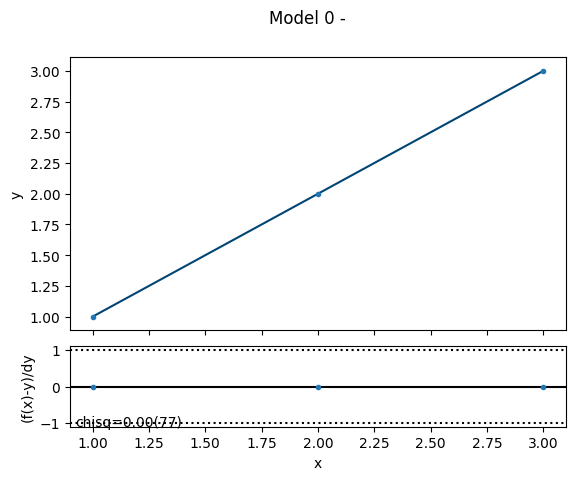

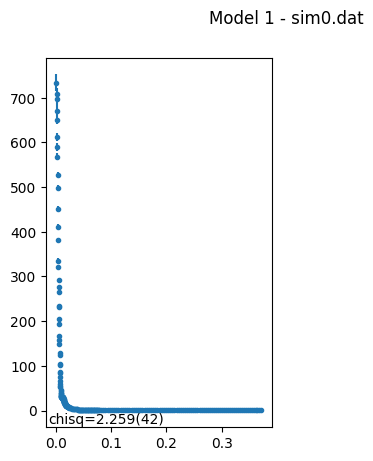

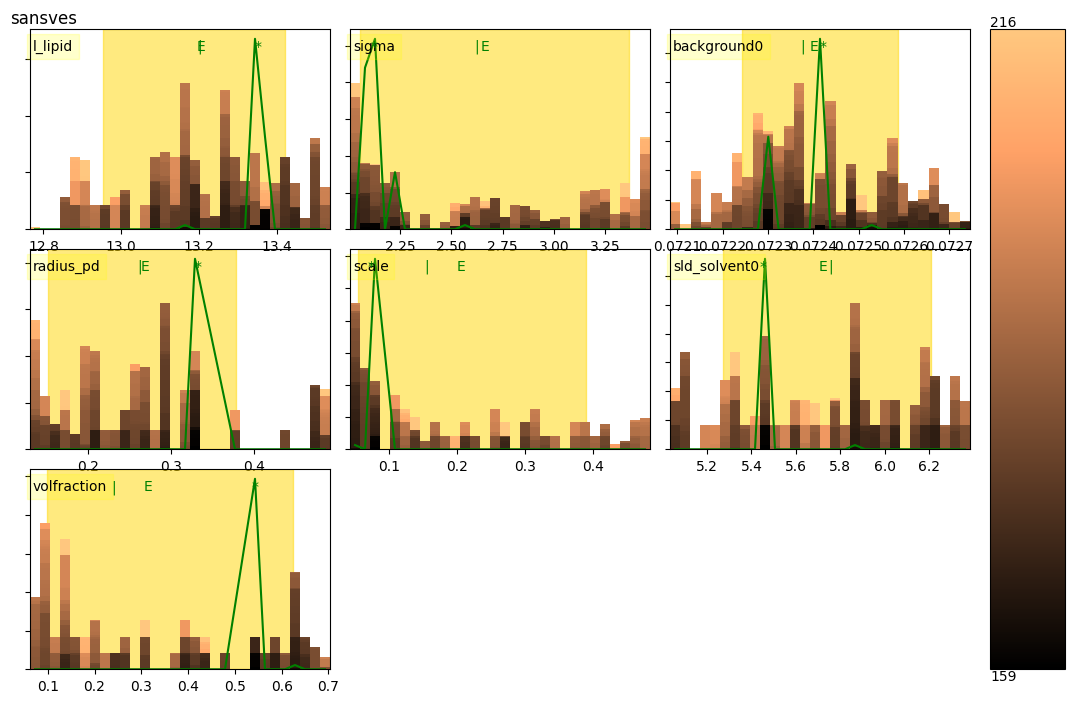

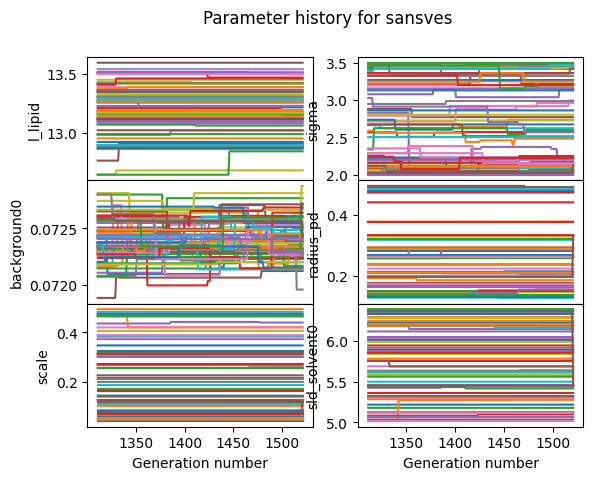

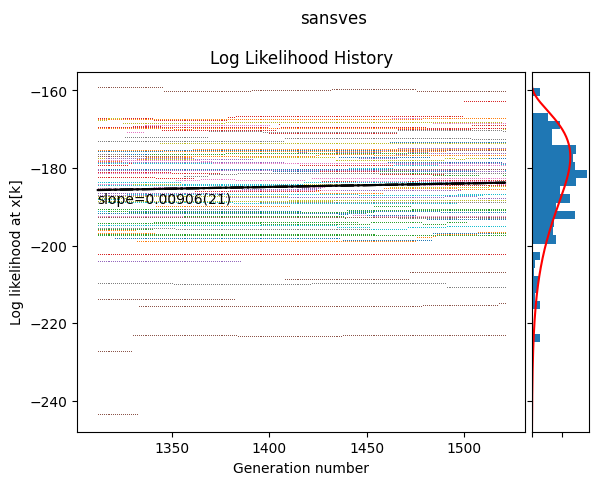

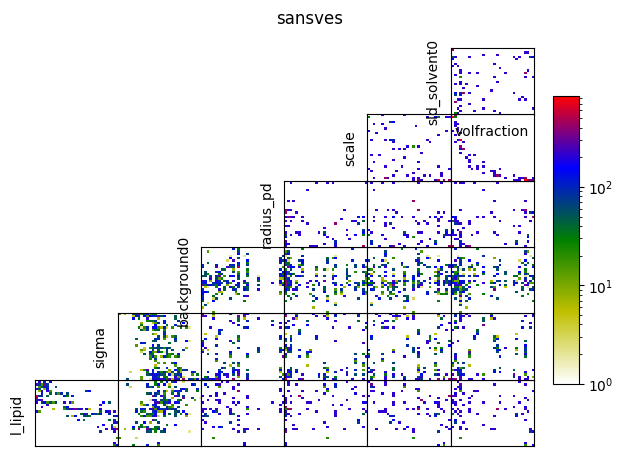

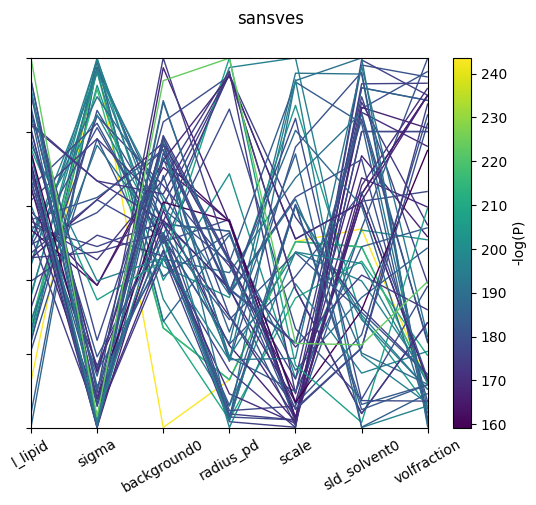

In [4]:
fitobj = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None,
)

if RunFit:
    fitobj.Interactor.fnRunMCMC(burn, steps, batch=False)

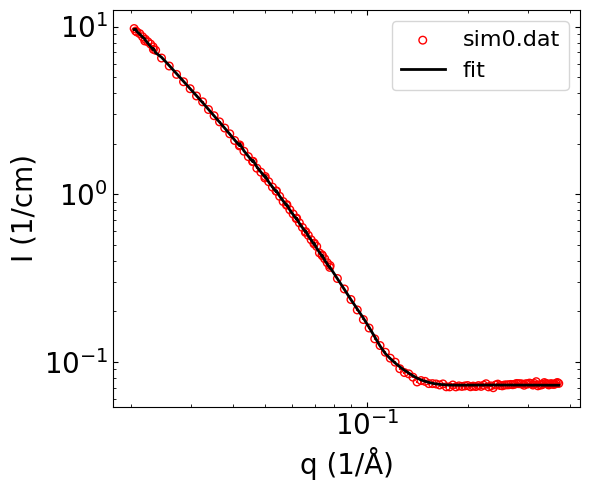

In [5]:
fitobj.fnRestoreFit()

pd = [None, data0.x[(data0.x >= qmin) & (data0.x <= qmax)]]
pd2 = [None, data0.dx[(data0.x >= qmin) & (data0.x <= qmax)]]

i=0
for M in fitobj.Interactor.problem.models:
    M.chisq()
    theo = M.fitness.theory()
    if not isinstance(M.fitness, bumps.curve.Curve):
        fig, ax = plt.subplots()
        ax.errorbar(pd[i], M.fitness.Iq, yerr=M.fitness.dIq, ls='none', color='r')
        ax.scatter(pd[i], M.fitness.Iq, s=30, marker='o', facecolors='none', edgecolors='r', label=M.fitness.name)
        ax.plot(pd[i], theo, label="fit", color='black', linewidth=2)
        ax.legend(loc="upper right", fontsize=16)
        plt.xlabel("q (1/Å)", fontsize=20)
        plt.ylabel("I (1/cm)", fontsize=20)
        ax.minorticks_on()
        ax.tick_params(which="both", direction="in", labelsize=20)
        ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
        ax.set_yscale('log')
        ax.set_xscale('log')
        #plt.xlim(0, 100)
        #plt.ylim(1e-3, 100)
        #plt.xticks(numpy.arange(-35, 36, 5.0))
        #plt.grid(True, which='Both')
        fig.patch.set_facecolor('white')
        ax.figure.set_size_inches(6, 5)
        plt.tight_layout()
        plt.savefig(os.path.join(store, "IvsQ"+str(i)), facecolor="white")
        plt.show()
        numpy.savetxt(os.path.join(store, "IvsQ"+str(i)+".dat"), numpy.c_[pd[i], M.fitness.Iq, M.fitness.dIq, pd2[i], theo], delimiter=' ', header="Q Iq dIq dQ fit")
    i+=1



In [6]:
sparse = 0.05
fitobj.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)

No StatDataPython.dat.
Recreate statistical data from sErr.dat.
Analysis of current MC simulation ...
Number of iterations: 711
     l_lipid  [      +|   ]  [        10,        15]  [     12.92(0.000),      13.19(0.000),      13.42(0.000)] (-    0.2712, +    0.2282)
       sigma  [|   -    | ]  [         2,       3.5]  [     2.048(0.000),      2.622(0.000),      3.366(0.000)] (-    0.5742, +    0.7437)
 background0  [   +       ]  [      0.01,       0.2]  [   0.07224(0.000),    0.07237(0.000),    0.07258(0.000)] (- 0.0001392, + 0.0002042)
   radius_pd  [  |  - |   ]  [      0.05,       0.5]  [    0.1552(0.000),     0.2599(0.000),     0.3782(0.000)] (-    0.1047, +    0.1183)
       scale  [ | -   |   ]  [    0.0001,       0.5]  [    0.0545(0.000),     0.1411(0.000),      0.373(0.000)] (-   0.08655, +     0.232)
sld_solvent0  [  |  -   | ]  [         5,       6.4]  [     5.283(0.000),       5.75(0.000),      6.207(0.000)] (-    0.4665, +    0.4573)
 volfraction  [ | -    |  ]  [      0.

Create bilayer statistics from above parameter statistics. Results are saved to bilayerplotdata.dat. Plot the median bilayer profile

In [7]:
fitobj.fnCreateBilayerPlotData()

Initializing ...
Pulling all molgroups ...
  substrate ...
Molecular group bilayer.substrate does not exist.
  siox ...
Molecular group bilayer.siox does not exist.
  tether ...
Molecular group bilayer.bME does not exist.
Molecular group bilayer.tetherg does not exist.
Molecular group bilayer.tether does not exist.
Molecular group bilayer.tether_bme does not exist.
Molecular group bilayer.tether_free does not exist.
Molecular group bilayer.tether_hg does not exist.
  innerhg ...
  innerhc ...
Molecular group bilayer.tether_methylene does not exist.
Molecular group bilayer.tether_methyl does not exist.
Molecular group bilayer.tether_methylene does not exist.
Molecular group bilayer.tether_methyl does not exist.
  outerhc ...
  outerhg ...
  protein ...
Molecular group protein does not exist.
Applying corrections ...

Calculating statistics ...

Saving data to bilayerplotdata.dat ...



In [8]:
fitobj.fnCalculateMolgroupProperty(fConfidence=-1)

Did not find any fractional envelopes ...
WaterFracHeadgroup1  [     0.468,     0.4772,     0.4872] (-  0.009206, +  0.009986)
WaterFracHeadgroup2  [    0.4172,     0.4312,     0.4468] (-   0.01404, +   0.01553)
WaterFracHydrocarbon  [   0.02083,    0.02789,    0.03705] (-  0.007061, +   0.00916)
WaterFracLipid1  [   0.02435,    0.03275,    0.04301] (-  0.008403, +   0.01026)
WaterFracLipid2  [   0.01636,    0.02321,    0.03104] (-   0.00685, +  0.007826)
WaterFracSubMembrane  [    0.9748,      0.982,     0.9874] (-  0.007178, +  0.005393)
bilayer.defect_hc_AVG  [         0,          0,          0] (-         0, +         0)
bilayer.defect_hc_COM  [     1e+05,      1e+05,      1e+05] (-         0, +         0)
bilayer.defect_hc_INT  [         0,          0,          0] (-         0, +         0)
bilayer.defect_hg_AVG  [         0,          0,          0] (-         0, +         0)
bilayer.defect_hg_COM  [     1e+05,      1e+05,      1e+05] (-         0, +         0)
bilayer.defect_hg_I

,element,lower_conf,median,upper_conf
0,WaterFracHeadgroup1,0.468009,0.477215,0.487201
1,WaterFracHeadgroup2,0.417185,0.431227,0.446760
2,WaterFracHydrocarbon,0.020825,0.027886,0.037046
3,WaterFracLipid1,0.024347,0.032750,0.043012
4,WaterFracLipid2,0.016363,0.023213,0.031039
5,WaterFracSubMembrane,0.974848,0.982026,0.987419
6,bilayer.defect_hc_AVG,0.000000,0.000000,0.000000
7,bilayer.defect_hc_COM,100000.000000,100000.000000,100000.000000
8,bilayer.defect_hc_INT,0.000000,0.000000,0.000000
9,bilayer.defect_hg_AVG,0.000000,0.000000,0.000000


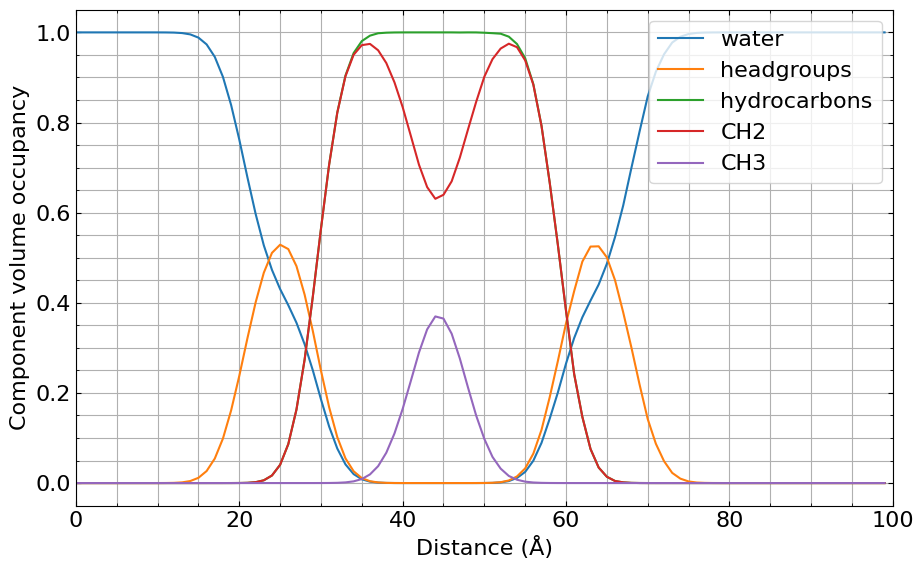

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

bilayer_plot_data = pd.read_csv(store + "/bilayerplotdata.dat", sep="\s", engine="python")

zax = bilayer_plot_data["zaxis"]

fig, ax = plt.subplots()
ax.plot(zax, bilayer_plot_data["water_corr_cvo"], label="water")
ax.plot(zax, bilayer_plot_data["innerhg_corr_cvo"] + bilayer_plot_data["outerhg_corr_cvo"], label="headgroups")
#ax.plot(zax, bilayer_plot_data["inner_cg_corr_cvo"] + bilayer_plot_data["outer_cg_corr_cvo"],label="cg")
#ax.plot(zax, bilayer_plot_data["inner_phosphate_corr_cvo"] + bilayer_plot_data["outer_phosphate_corr_cvo"], label="phosphate")
#ax.plot(zax, bilayer_plot_data["inner_choline_corr_cvo"] + bilayer_plot_data["outer_choline_corr_cvo"], label="choline")
ax.plot(zax, bilayer_plot_data["innerhc_corr_cvo"]+bilayer_plot_data["outerhc_corr_cvo"], label="hydrocarbons")
ax.plot(zax, bilayer_plot_data["innerch2_corr_cvo"]+bilayer_plot_data["outerch2_corr_cvo"], label="CH2")
ax.plot(zax, bilayer_plot_data["innerch3_corr_cvo"]+bilayer_plot_data["outerch3_corr_cvo"], label="CH3")
ax.legend(loc="upper right", fontsize=16)
plt.xlabel("Distance (Å)", fontsize=16)
plt.ylabel("Component volume occupancy", fontsize=16)
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=16)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.xlim(0, 100)
#plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
plt.tight_layout()
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(10, 6)
plt.savefig(os.path.join(store, "CVO_profile"), facecolor="white")
plt.show()